## Import essentials

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series 
import datetime
from pytz import timezone 
import seaborn as sns
from collections import OrderedDict
import time
import dateutil.parser
import isodate 
from wordcloud import WordCloud, STOPWORDS 
import warnings
warnings.filterwarnings("ignore")

## API used

In [16]:
# api key from youtube data api v3
api_key = ""

In [17]:
from apiclient.discovery import build
youtube = build('youtube','v3',developerKey = api_key)
type(youtube) # check the type 

googleapiclient.discovery.Resource

# Youtube Video Data

YoutubeVideoData is class specifically created for data collection and has the following methods
- getVideoStats()
- getVideos()
- write_to_df()
- videoData()

### Get video statistics from youtube

- Get the video statistics like views,likes,dislikes,duration,favourite comment and comment
- Statistics are for first 50 videos

In [18]:
class YoutubeVideoData:
    def getVideoStats(self,videoIds):
        '''
        Returns video statistics for first 50 videos.
                Parameters:
                        videoIds): list of video ids
                Returns:
                        stats: list of dictionaries of video statistics 
                             - viewCount
                             - likeCount
                             - dislikeCount
                             - favoriteCount
                             - CommentCount
                             - duration
        '''
        stats = []
        res1 = youtube.videos().list(id = videoIds,part = "statistics").execute()
        res2 = youtube.videos().list(id = videoIds,part = "contentDetails").execute()

        for stat, details in zip(res1['items'],res2['items']):
            stats.append({
                'viewCount': float(stat['statistics'].get('viewCount',np.nan)),
                'likeCount': float(stat['statistics'].get('likeCount',np.nan)),
                'dislikeCount': float(stat['statistics'].get('dislikeCount',np.nan)),
                'favoriteCount': float(stat['statistics'].get('favoriteCount',np.nan)),
                'commentCount': float(stat['statistics'].get('commentCount',np.nan)),
                'duration': (details['contentDetails']['duration']),
            }) 

        return stats

### Search Content on Youtube

- searching for video of given topic and max number of videos

In [19]:
class YoutubeVideoData(YoutubeVideoData):
    def getVideos(self,max_number_of_videos,topic):
        '''
        Returns videos in json, time queried and video statistics.
                Parameters:
                        max_number_of_videos: integer denoting maximum number of videos
                Returns:
                        videos : videos in json format
                        timeQueried : list of query time. Same time for first 50 videos
                        videoStats : list of dictionaries of video statistics
        '''
        pageToken = None
        videos =[] # contains all videos
        videoStats =[] # contains all statistics of videos
        timeQueried = [] # time queried per 50 results
        count = 0
        maxResults = 50 if(max_number_of_videos >50) else max_number_of_videos
        while count < max_number_of_videos :
            # time queried
            x = datetime.datetime.now(timezone('Asia/Kolkata'))
            timeQueried.append(x)

            # search youtube videos
            result = youtube.search().list(q = topic, 
                                           part = 'snippet', 
                                           type = 'video',
                                           maxResults= maxResults,
                                           pageToken = pageToken).execute()

            videos += result['items']

            if(len(result['items'])!=0):
                videoIds = list(map(lambda x : x.get('id').get('videoId'),result['items']))
                if(len(videoIds)!=0 ):
                    videoStats += self.getVideoStats(videoIds)
            else:
                break
            pageToken = result.get('nextPageToken')
            if(pageToken == None):
                break
        
            if(max_number_of_videos <=50):
                break
            
            count +=50
            time.sleep(5)

        return videos,timeQueried,videoStats

### Writing video data in dataframe

Writes the given data(in json format) to a dataframe

In [20]:
class YoutubeVideoData(YoutubeVideoData):
    def write_to_df(self,videos,timeQueried,videoStats,topic):
        '''
        Returns dataframe object of videos statistics.
                Parameters:
                        videos : videos in json format
                        timeQueried : list of query time. Same time for first 50 videos
                        videoStats : list of dictionaries of video statistics
                Returns:
                        df : dataframe object with the following columns.
                           - Video_Title
                           - Video_ID
                           - Published_At
                           - duration
                           - viewCount
                           - likeCount
                           - dislikeCount
                           - favoriteCount
                           - commentCount
        '''
        data = {
            "Video_Title":[],
            "Video_ID":[],
            "Published_At":[],
            "duration":[], 
            "viewCount":[], 
            "likeCount":[], 
            "dislikeCount":[],
            "favoriteCount":[],
            "commentCount":[],
        }

        for video,stats in zip(videos,videoStats):
            data["Video_Title"].append(video['snippet']['title'])
            data["Video_ID"].append(video['id']['videoId'])
            data["Published_At"].append(dateutil.parser.parse(str(video['snippet']['publishedAt'])) )
            data['duration'].append(stats['duration'])
            data['viewCount'].append(stats['viewCount'])
            data['likeCount'].append(stats['likeCount'])
            data['dislikeCount'].append(stats['dislikeCount'])
            data['favoriteCount'].append(stats['favoriteCount'])
            data['commentCount'].append(stats['commentCount'])
        
        df = DataFrame(data)
        df["topic"] = topic
        df["TimeQueried"] = 0
        for i in range(len(timeQueried)):
            df['TimeQueried'][i*50:(i+1)*50] = timeQueried[i]
        return df

### Get video data from youtube in one shot
Use this function to get all the data for required topics and max number of videos on each topic in one go

In [21]:
class YoutubeVideoData(YoutubeVideoData):
    def videoData(self,max_number_of_videos, topics):  
        '''
        Returns videoData for given topics list and puts all the data in one csv file.
                Parameters:
                        max_number_of_videos: integer denoting maximum number of videos
                        topics : list of topics to be searched for in youtube
                Returns:
                        df : dataframe object for video data
        '''
        df = DataFrame()
        for topic in topics:
            videos, timeQueried, videoStats = self.getVideos(max_number_of_videos, topic)
            df = df.append(self.write_to_df(videos, timeQueried, videoStats, topic),ignore_index=True,sort=False)
            time.sleep(10)
        
        # date on which data is collected
        df["DateQueried"] = 0
        df["DateQueried"] = datetime.datetime.now(timezone('Asia/Kolkata'))
        
        # Specified order
        df = df[['topic', 'TimeQueried', 'Video_Title','Video_ID', 
                 'Published_At', 'duration', 'viewCount', 'likeCount', 
                 'dislikeCount','favoriteCount','commentCount',"DateQueried"]]
        return df

# Data preprocessing

Data variable transformations.
PreprocessData is a class specifically designed for cleaning and normalising (z-score) the data. It contains the following methods.

- order()
- removeDuplicates()
- formatPublishedDate()
- formatDuration()
- formatTimeQueried()
- formatDateQueried()
- fillMissing()
- standardization()
- preprocessData()

and member varibles
- stats
- indices
- df

### Stats, indices, df
- **indices**: Getting the indices at which the next topic starts 
- **stats**: Getting the column headers for which missing values are to be filled (eg. viewCount)
- **df** : keeps and internal copy of dataframe to be cleaned

In [22]:
class PreprocessData(YoutubeVideoData):
    stats = None # fill the values for pre defined columns
    indices = [0]
    df = None
    def __init__(self,df):
        self.df = DataFrame(df)
        self.order()
        self.stats = list(self.df.loc[0].index[6:11])
        for i in range(len(topics)):
            self.indices.append(self.indices[i]+(sum((df['topic'] == topics[i]))))
        

### Drop other columns except the required ones
- Maintains the specified order of columns
- Drops unnecessary columns

In [23]:
class PreprocessData(PreprocessData):
    def order(self):
        self.df = self.df[['topic', 'TimeQueried', 'Video_Title','Video_ID', 
                 'Published_At', 'duration', 'viewCount', 'likeCount', 
                 'dislikeCount','favoriteCount','commentCount',"DateQueried"]]

### Drop Duplicates
- Drops any duplicate data present in df based on Video_ID (which is obviously unique for each video)

In [24]:
class PreprocessData(PreprocessData):
    def removeDuplicates(self):
        self.df.drop_duplicates(subset ="Video_ID", keep = False, inplace = True) 

### Published at 
- Formats the published date of video in datetime format

In [25]:
class PreprocessData(PreprocessData):
    def formatPublishedDate(self):
        # Transforming publish_time to datetime
        self.df['Published_At'] = pd.to_datetime(self.df['Published_At']).dt.date

### Duration
- Formats the duration of video using isodate.parse_duration()

In [26]:
class PreprocessData(PreprocessData):
    def formatDuration(self):
        durations = []
        for duration in self.df.duration:
            durations.append(isodate.parse_duration(duration))
        self.df['duration'] = durations

###  Time Queried
- Formats the queried time of the video in datetime format

In [27]:
class PreprocessData(PreprocessData):
    def formatTimeQueried(self):
        # Transforming query time to datetime
        self.df['TimeQueried'] = pd.to_datetime(self.df.TimeQueried).dt.time

### Date Queried
- Formats the Date queried of video in datetime format

In [28]:
class PreprocessData(PreprocessData):
    def formatDateQueried(self):
        # Transforming date queried to datetime
        self.df['DateQueried'] = pd.to_datetime(self.df['DateQueried']).dt.date

### Fill the missing values
- The missing values in the data are filled by the mean of the data which is above and below of them.

In [29]:
class PreprocessData(PreprocessData):
    def fillMissing(self,data):
        for stat in self.stats:
            mean = data[stat].mean()
            data[stat] = data[stat].fillna(mean)
        return data

### Standardization (also called z-score normalization)
Z score is calculated using <br>
<center style="font-size:large;">
    $
     Z = \cfrac{ X - \bar{X}}{\sigma }
    $
</center>

In [30]:
class PreprocessData(PreprocessData):
    def standardization(self,data):
        for stat in self.stats:
            mean = data[stat].mean()
            std  = data[stat].std()
            if(std!=0):
                data[stat] = (data[stat]-mean)/std
        return data

### Preprocess data in one go
All the above functions are bundled in this function to process the data in one go

In [31]:
class PreprocessData(PreprocessData):
    def preprocessData(self):
        self.order()
        self.removeDuplicates()
        self.formatPublishedDate()
        self.formatDuration()
        self.formatTimeQueried()
        self.formatDateQueried()
        self.order()
        for i in range(len(topics)):
            self.df[self.indices[i]:self.indices[i+1]] = self.fillMissing(self.df[self.indices[i]:self.indices[i+1]])
        for i in range(len(topics)):
            self.df[self.indices[i]:self.indices[i+1]] = self.standardization(self.df[self.indices[i]:self.indices[i+1]])
        return self.df

# Working with the YoutubeVideoData class

In [32]:
# YoutubeVideoData object that will used to collecting data from youtube
youtubeData = YoutubeVideoData()

In [33]:
# list of topics that will be searched on youtube for data collection
topics = ["Calculus","Competetive Programming","Cryptography"]

### Idea:
- First I executed the below on a particular date (18-08-2020) and data is stored in 'data1'
- Then I executed the next cell on another date (20-08-2020) and data is stored in 'data2'
- Combined both the data frames is stoed in 11840520_data.csv

In [388]:
data1 = youtubeData.videoData(max_number_of_videos,topics) # first run

In [111]:
data2 = youtubeData.videoData(max_number_of_videos,topics) # second run

## Write data to 11840520_data.csv

In [161]:
# original data
originalData = (data1.append(data2, ignore_index=True))
originalData.to_csv("11840520_data.csv", encoding='utf-8')

## Clean the data
Clean data1 and store the cleaned data in df

In [38]:
preprocessor = PreprocessData(data1) # object
df = preprocessor.preprocessData() 

Clean data2 and store the cleaned data in df2

In [39]:
preprocessor = PreprocessData(data2) # object
df2 = preprocessor.preprocessData()

## Write the cleaned data to csv
I have put the cleaned data in 11840520_cleaned_data.csv for reference

In [173]:
cleanedData = df.append(df2, ignore_index=True)
cleanedData.to_csv("11840520_cleaned_data.csv", encoding='utf-8')


# Working on score and Playlist Creation

- Create a dataframe object (bigdata) with more columns added like delta_viewCount, delta_likes etc. .
- 'bigdata' contains the video which are present in both 'df' and 'df2'

In [40]:
# delta signifies the change in the values
delta = ['delta_viewCount','delta_likeCount','delta_dislikeCount','delta_favoriteCount','delta_commentCount']
for d in delta:
    df[d] = 0

bigdata = DataFrame()

for index, row in df.iterrows(): 
    
    # extract the row from df2 which is also present in df1
    values =  (df2.loc[df2['Video_ID'] == row['Video_ID']])
    
    # check whether it is empty or not
    if(values.empty == False):
        
        # put the difference of the statistics in bigdata
        for d in delta:
            row[d] = float(values[d.split('_')[1]]) - float(row[d])
        bigdata = bigdata.append(row)
        
# ordering the data
bigdata = bigdata[['topic', 'TimeQueried', 'Video_Title','Video_ID', 
                 'Published_At', 'duration', 'viewCount', 'likeCount', 
                 'dislikeCount','favoriteCount','commentCount',"DateQueried",
                 'delta_viewCount','delta_likeCount','delta_dislikeCount',
                 'delta_favoriteCount','delta_commentCount']]

## Scoring function

- Uses borda's methods for scoring the videos
- The following statistics are put in ascending order
    - likeCount
    - commentCount
    - favoriteCount
    - viewCount
    - delta_viewCount
    - delta_likeCount
    - delta_favoriteCount
    - delta_commentCount
- The following statistics are put in descending order
    - dislikeCount
    - delta_dislikeCount

In [41]:
# Getting the columns which are used for borda method
cols = list(bigdata.loc[0].index[6:11]) + list(bigdata.loc[0].index[12:])
print(cols)

# tells whether to sort data of 'cols' in ascending(1) or descending(0)
# dislikeCount and delta_dislikeCount are sorted in ascending order
# rest are sorted in descending order
truth = [0,0,1,0,0,0,0,1,0,0]

['viewCount', 'likeCount', 'dislikeCount', 'favoriteCount', 'commentCount', 'delta_viewCount', 'delta_likeCount', 'delta_dislikeCount', 'delta_favoriteCount', 'delta_commentCount']


In [42]:
# scoring function
def scores(df):
    borda = [] # stores the columns of Video_IDs
    for i in range(len(truth)):
        
        # Extract the Video_IDs in sorted order of the truth values and append it to borda
        series = df.sort_values(by=[cols[i]], ascending=truth[i])['Video_ID']
        borda.append(list(series))
    
    # stores in final score of all videos
    # values in 'score' will be incremented as we run through 'borda' row by row 
    score = dict.fromkeys(df['Video_ID'].to_list() , 0)
    
    # stores the frequency of Video_IDs in a particular row
    freq = {}
    
    # all rows in borda has same length
    # used to traversal
    l = len(borda[0])
    
    for i in range(l):
        
        freq.clear()
        for b in borda:
            
            if b[i] in freq.keys():
                freq[b[i]] +=1
            else:
                freq[b[i]] = 1
                
        # frequencies are multiplied by the corresponding row indices and then 'score' for that Video_ID
        # is incremented
        for f in freq:
            freq[f] *= (i+1)
            score[f] += freq[f]
            
    # final score is a list of 2 element tuples("Video_ID",score) in sorted order (ascending)       
    finalScore = (list(sorted(score.items(), key=lambda x: x[1],reverse=False)))
    
    # 'dg' contains the data with 'score' column added 
    dg = DataFrame()
    df['Score'] = 0
    
    for i in finalScore:
        videoId = i[0]
        score_value = i[1]
        
        row = df.loc[df['Video_ID'] == videoId]
        row['Score'] = score_value
        
        dg = dg.append(row)
        
    dg['topic'] = df['topic']
    
    # order the data
    dg = dg[['topic', 'TimeQueried', 'Video_Title','Video_ID', 
         'Published_At', 'duration', 'viewCount', 'likeCount', 
         'dislikeCount','favoriteCount','commentCount','Score']]
    return dg

### Top videos

-  According to the maximum duration specifed, returns playlist 

In [43]:
def topVideos(data):
    # maximum duration (7 hrs) in seconds
    max_duration = datetime.timedelta(hours = 10, minutes = 0, seconds = 0).total_seconds()
    playlist = DataFrame()
    
    # counter to count the total duration of playlist
    count =  datetime.timedelta(hours = 0, minutes = 0, seconds = 0)
    
    for index, row in data.iterrows(): 
        playlist = playlist.append(row)
        count += row["duration"]
        
        # breaks when the total duration of playlist is greater than max duration
        if count.total_seconds() - max_duration >=0:
            break
    return playlist

### Getting the indices at which the next topic starts (indices)
This is for 'bigdata'

In [44]:
indices = [0]
for i in range(len(topics)):
        indices.append(indices[i]+(sum((bigdata['topic'] == topics[i]))))
print(indices)

[0, 256, 553, 943]


## Create Playlists

- Extract the data from 'bigdata' for each topic and call the scoring function 
- Put the returned data in 'scored_output'
- Call 'topVideos()' to create a playlist for the topic
- Append all the playlist in a list called dg

In [45]:
dg = [] # contains playlists for topics
scored_output = DataFrame()
for i in range(len(topics)):
    data = (scores(bigdata[indices[i]:indices[i+1]]))
    scored_output = scored_output.append(data)
    playlist = topVideos(data)
    playlist = playlist[['topic', 'TimeQueried', 'Video_Title','Video_ID', 
         'Published_At', 'duration', 'viewCount', 'likeCount', 
         'dislikeCount','favoriteCount','commentCount','Score']]
    dg.append(playlist)

## Final Playlists

- 'scored_output' contains all the videos which are scored using the alogrithm
- 'dg' is a list of dataframes which is the real playlists of topics


In [180]:
scored_output.to_csv("scored_output.csv",encoding='utf-8') # writes the scored output data to csv

In [46]:
dg[0]

,topic,TimeQueried,Video_Title,Video_ID,Published_At,duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Score
347,Calculus,09:04:54.199671,Derivative formulas through geometry | Essence...,S0_qX4VJhMQ,2017-04-30,00:18:43,1.906349,2.179026,0.335264,0.0,2.201899,526.0
345,Calculus,09:04:54.199671,Visualizing the chain rule and product rule | ...,YG15m2VwSjA,2017-05-01,00:16:52,1.000209,1.187285,0.080758,0.0,0.861404,538.0
363,Calculus,09:05:00.948841,The paradox of the derivative | Essence of cal...,9vKqVkMQHKk,2017-04-29,00:17:57,2.387241,2.917829,0.824359,0.0,2.408301,566.0
252,Calculus,09:04:46.836330,Fundamental Theorem of Calculus Part 1,PGmVvIglZx8,2008-11-22,00:09:26,1.722638,0.411015,0.229035,0.0,0.821021,670.0
1,Calculus,09:04:12.372046,Why Calculus? - Lesson 1 | Don&#39;t Memorise,IBoAm4mZNxc,2019-01-22,00:10:04,0.358055,0.535212,0.439280,0.0,0.847943,672.0
265,Calculus,09:04:46.836330,Integration and the fundamental theorem of cal...,rfG8ce4nNh0,2017-05-05,00:20:46,1.024756,1.129890,0.167069,0.0,0.551800,680.0
418,Calculus,09:05:07.796555,Calculus 2 Lecture 6.1: The Natural Log Function,H9eCT6f_Ftw,2014-01-18,02:22:46,0.952779,0.029337,-0.175962,0.0,0.178256,712.0
398,Calculus,09:05:00.948841,Stand and Deliver (1988) - I Want to Teach Cal...,a81pNygdAXw,2017-06-27,00:02:19,0.582899,-0.048704,-0.142765,0.0,0.057107,719.0
0,Calculus,09:04:12.372046,1. What is Calculus | (Hindi),2n41IqOMbdc,2016-01-22,00:04:23,0.485720,0.448242,0.518952,0.0,0.328571,722.0
338,Calculus,09:04:54.199671,Introduction to l&#39;Hôpital&#39;s rule | Der...,PdSzruR5OeE,2010-06-07,00:08:52,1.693805,0.027663,0.125020,0.0,-0.028147,739.0


In [47]:
dg[1]

,topic,TimeQueried,Video_Title,Video_ID,Published_At,duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Score
961,Competetive Programming,09:07:10.985455,Quantitative Aptitude tricks | What is Aptitud...,MVq1WHkTVbc,2019-02-19,00:02:52,-0.167316,-0.126462,-0.141065,0.0,-1.626316e-01,641.0
597,Competetive Programming,09:06:23.641699,How to start Competitive Programming?,FbW_5ipDCbg,2018-07-09,00:02:52,0.217399,0.183108,0.328625,0.0,-8.872118e-02,677.0
942,Competetive Programming,09:07:04.261540,Get Your Dream Job 1-3Lacs/Month Just After yo...,aTMW9uu9Ro8,2020-05-07,00:15:17,-0.170018,-0.126259,-0.141065,0.0,-1.626316e-01,701.0
973,Competetive Programming,09:07:10.985455,Complete Advance Computer Class || NCERT Based...,c6mfyWS43s0,2020-02-01,03:36:44,-0.084239,0.032136,0.090837,0.0,2.666727e-02,704.0
986,Competetive Programming,09:07:10.985455,#loksewatips#loksewaiqtricks#naphanoksan Lokse...,5h86lFWJAfw,2020-06-27,00:06:35,-0.169791,-0.121071,-0.141065,0.0,-1.213741e-01,714.0
953,Competetive Programming,09:07:10.985455,"Day 0 : Hello World, 30 days of code Challenge...",79vQ8fOPEpg,2018-08-15,00:07:10,-0.149612,-0.114458,-0.127424,0.0,-9.467814e-02,715.0
960,Competetive Programming,09:07:10.985455,Plant Breeding: Apomixis in Plants (General Ag...,8pZWKAUk2q0,2020-05-09,00:04:21,-0.171020,-0.128497,-0.141065,0.0,-3.448844e-17,721.0
965,Competetive Programming,09:07:10.985455,Indian Polity || Making of Constitution 2|| GK...,9l1IF2QGR7c,2020-06-03,00:19:43,-0.170939,-0.124631,-0.141065,0.0,-1.577777e-01,750.0
906,Competetive Programming,09:07:04.261540,JEE 2020 -Area under the curve PAST YEAR QUEST...,estH4XPKhVU,2019-07-07,00:24:31,-0.048288,0.014944,0.019220,0.0,2.620774e-01,773.0
1022,Competetive Programming,09:07:17.729165,Preparation Strategy to get in your Dream Comp...,EMsFRPGn4zo,2020-08-14,00:12:38,-0.168640,-0.117510,-0.141065,0.0,-8.254360e-02,790.0


In [48]:
dg[2]

,topic,TimeQueried,Video_Title,Video_ID,Published_At,duration,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Score
1488,Cryptography,09:09:17.996418,Cryptography 101 - - XOR Cipher,xK_SqWG9w-Y,2017-08-13,00:05:34,-0.026968,0.032477,-0.129427,0.0,0.056275,734.0
1448,Cryptography,09:09:11.493978,Imp Question on Network Security | Symmetric K...,JUi2x_WbVO0,2019-01-30,00:08:26,-0.087025,-0.037890,-0.154154,0.0,-0.079466,856.0
1450,Cryptography,09:09:11.493978,"Cryptography/SSL 101 #1: public, private and s...",bRBJ_0I919E,2016-02-06,00:50:29,0.115288,0.063245,-0.005790,0.0,0.293822,887.0
1462,Cryptography,09:09:11.493978,[HINDI] Workshop on Network Security and Crypt...,3m81p56oqRY,2019-08-04,00:28:30,0.082119,0.265517,0.117847,0.0,0.348119,901.0
1399,Cryptography,09:09:04.674210,Dealing Cards with Cryptography (with Ron Rive...,mthPiiCS24A,2018-03-22,00:11:25,0.953922,1.003431,0.488758,0.0,0.857149,919.0
1480,Cryptography,09:09:17.996418,Diffie-hellman key exchange | Journey into cry...,M-0qt6tdHzk,2014-04-28,00:02:19,1.594940,0.058430,0.018937,0.0,0.005372,922.0
1493,Cryptography,09:09:17.996418,Diffi Hellman Key Exchange Algorithm | Cryptog...,zLNug0LrFiU,2019-11-12,00:15:25,-0.019097,0.031139,-0.079972,0.0,0.059669,925.0
1429,Cryptography,09:09:11.493978,How Quantum Computers Break Encryption | Shor&...,lvTqbM5Dq4Q,2019-05-01,00:17:31,13.684199,16.092422,16.042278,0.0,15.513811,950.0
1385,Cryptography,09:09:04.674210,What is Modular Arithmetic - Introduction to M...,Eg6CTCu8iio,2014-07-25,00:04:48,1.756753,0.773067,1.008032,0.0,0.300609,973.0
1387,Cryptography,09:09:04.674210,Symmetric Key and Public Key Encryption,ERp8420ucGs,2013-06-18,00:06:45,4.050310,0.630461,2.998586,0.0,0.507615,992.0


# Data Visualisation

## Let's start looking if Views, likes, dislikes and comment counts have a normal distribuition

In [52]:
def displot(df,topic):
    print(topic)
    likeCount_log = (df['likeCount'] + 1)
    viewCount_log = (df['viewCount'] + 1)
    dislikeCount_log = (df['dislikeCount'] + 1)
    commentCount_log = (df['commentCount'] + 1)

    plt.figure(figsize = (10,4))
    
    plt.subplot(221)
    g1 = sns.distplot(viewCount_log)
    g1.set_title("VIEWS DISTRIBUITION", fontsize=10)

    plt.subplot(224)
    g2 = sns.distplot(likeCount_log,color='green')
    g2.set_title('LIKESDISTRIBUITION', fontsize=10)

    plt.subplot(223)
    g3 = sns.distplot(dislikeCount_log, color='r')
    g3.set_title("DISLIKES DISTRIBUITION", fontsize=10)

    plt.subplot(222)
    g4 = sns.distplot(commentCount_log)
    g4.set_title("COMMENTS DISTRIBUITION", fontsize=10)

    plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 2)

    plt.show()

Calculus


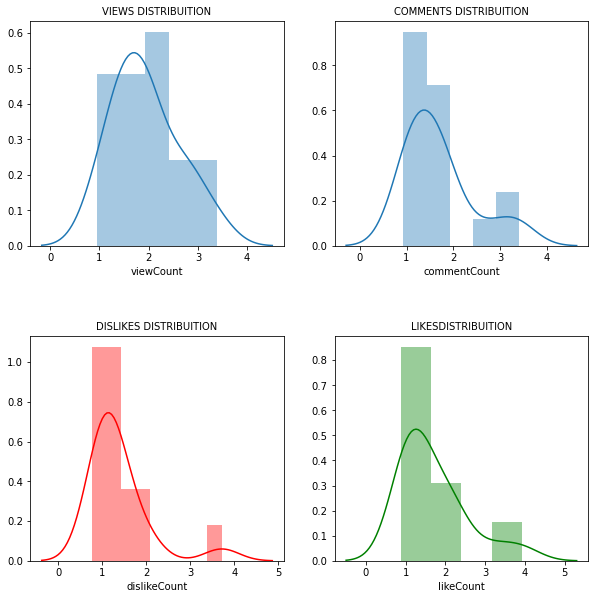

Views quantiles
0.01   -0.042189
0.25    0.485720
0.50    0.952779
0.75    1.235911
0.99    2.310299
Name: viewCount, dtype: float64

Likes quantiles
0.01   -0.102407
0.25    0.057158
0.50    0.411015
0.75    1.134752
0.99    2.799621
Name: likeCount, dtype: float64

Dislikes quantiles
0.01   -0.220578
0.25   -0.001127
0.50    0.162642
0.75    0.439280
0.99    2.452759
Name: dislikeCount, dtype: float64

Comment quantiles
0.01   -0.062068
0.25    0.178256
0.50    0.551800
0.75    0.847943
0.99    2.375277
Name: commentCount, dtype: float64
Competetive Programming


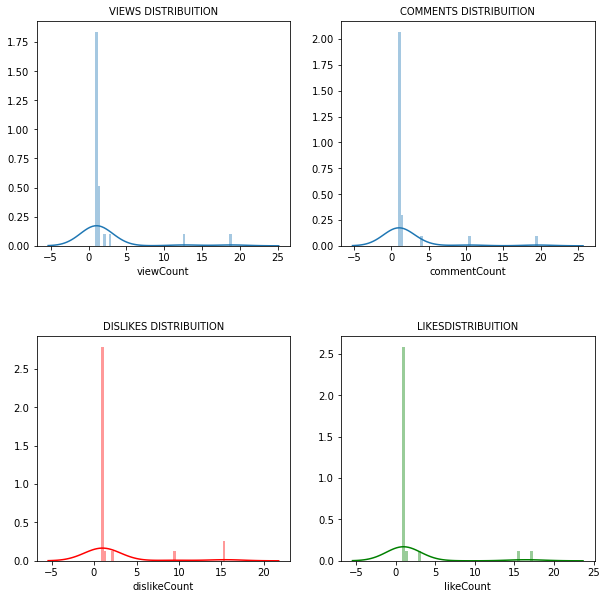

Views quantiles
0.01    -0.170999
0.25    -0.166922
0.50    -0.149612
0.75     0.252869
0.99    16.301428
Name: viewCount, dtype: float64

Likes quantiles
0.01    -0.127968
0.25    -0.119290
0.50    -0.108151
0.75     0.023540
0.99    15.871801
Name: likeCount, dtype: float64

Dislikes quantiles
0.01    -0.141065
0.25    -0.141065
0.50    -0.083090
0.75     0.082311
0.99    14.466985
Name: dislikeCount, dtype: float64

Comment quantiles
0.01    -0.162632
0.25    -0.120161
0.50    -0.082544
0.75     0.065498
0.99    16.228609
Name: commentCount, dtype: float64
Cryptography


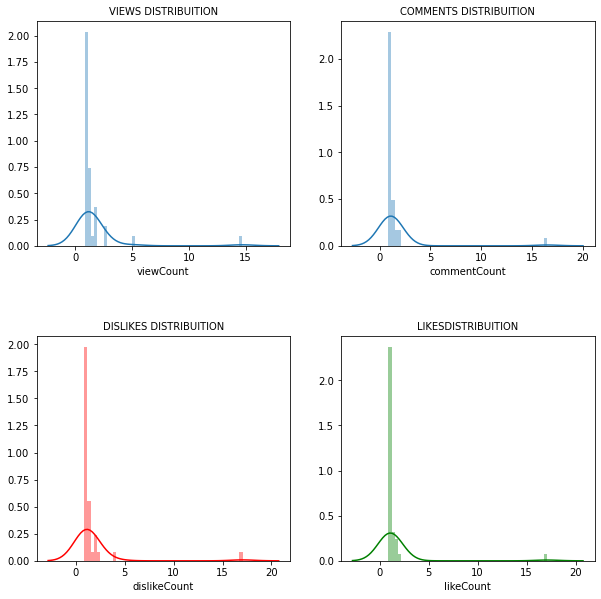

Views quantiles
0.01    -0.146591
0.25    -0.018283
0.50     0.105516
0.75     0.347171
0.99    10.023321
Name: viewCount, dtype: float64

Likes quantiles
0.01    -0.099727
0.25    -0.043107
0.50     0.032477
0.75     0.180836
0.99    10.358606
Name: likeCount, dtype: float64

Dislikes quantiles
0.01    -0.154154
0.25    -0.086154
0.50    -0.005790
0.75     0.297120
0.99    11.085675
Name: dislikeCount, dtype: float64

Comment quantiles
0.01   -0.134577
0.25   -0.070982
0.50    0.025733
0.75    0.264977
0.99    9.979097
Name: commentCount, dtype: float64


In [54]:
for i in range(len(topics)):
    displot(dg[i],topics[i])
    print("Views quantiles")
    print(dg[i]['viewCount'].quantile([.01,.25,.5,.75,.99]))
    print("")
    print("Likes quantiles")
    print(dg[i]['likeCount'].quantile([.01,.25,.5,.75,.99]))
    print("")
    print("Dislikes quantiles")
    print(dg[i]['dislikeCount'].quantile([.01,.25,.5,.75,.99]))
    print("")
    print("Comment quantiles")
    print(dg[i]['commentCount'].quantile([.01,.25,.5,.75,.99]))

## Rankings
Displays the top ten videos with score

In [160]:
def ranking(df,topic):
    sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})
    tmp = df[:10]
    g = sns.barplot(y=tmp.Video_Title,x=tmp.Score)
    plt.title(topic)
    plt.show(g)

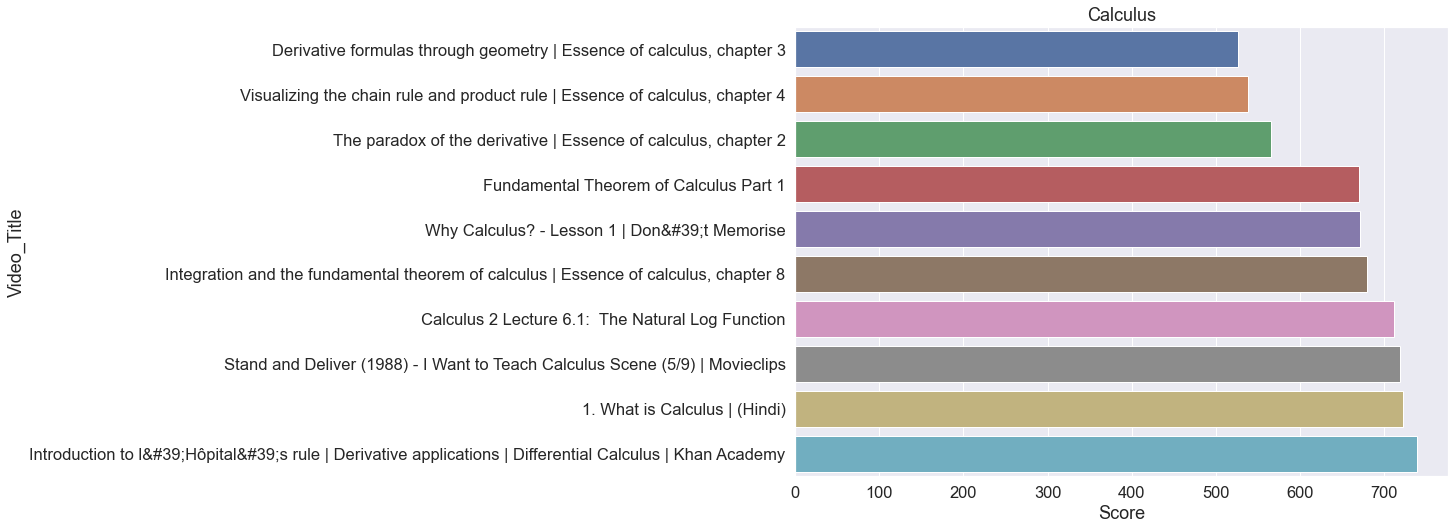

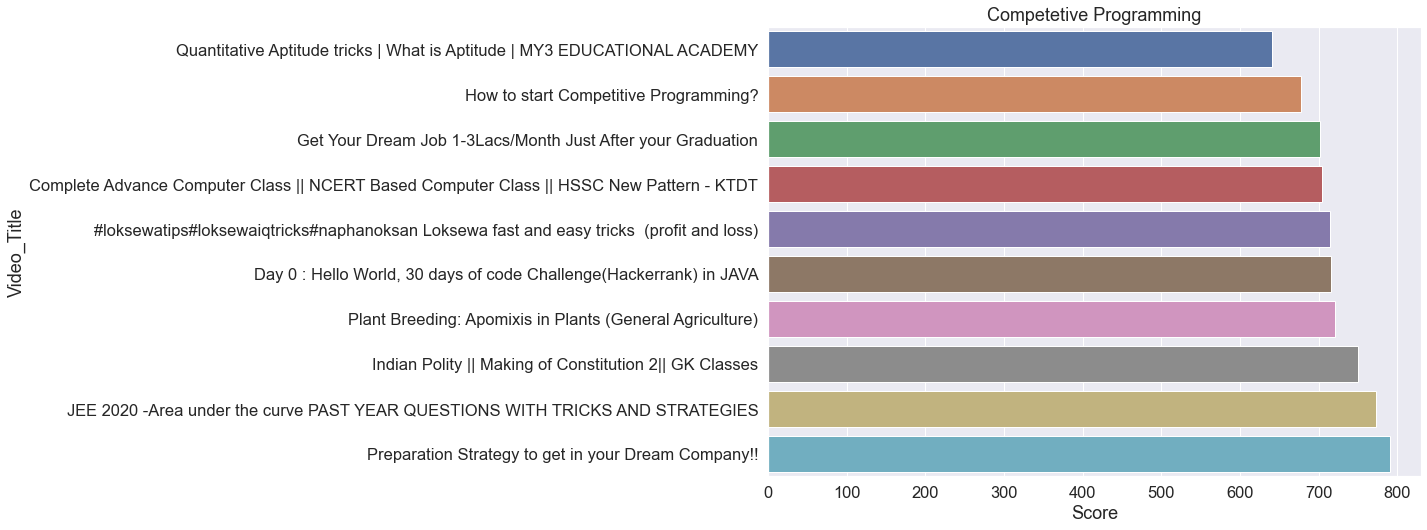

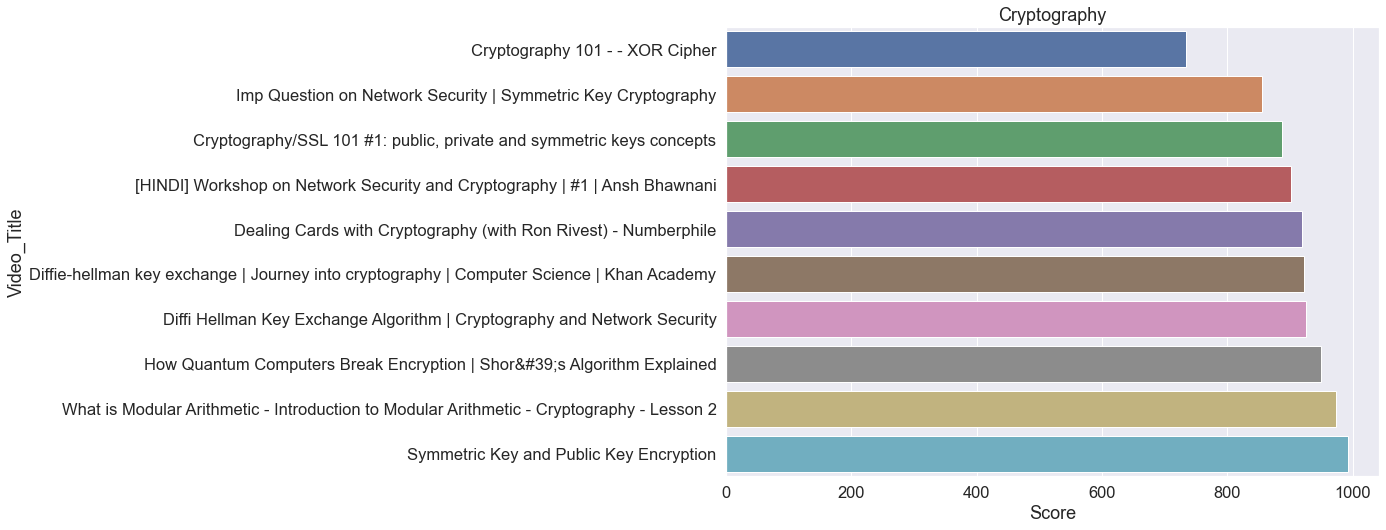

In [161]:
for i in range(len(topics)):
    ranking(dg[i],topics[i])

## duration - score distribution

Tells the duration of videos who got the best score (low score is the best score)

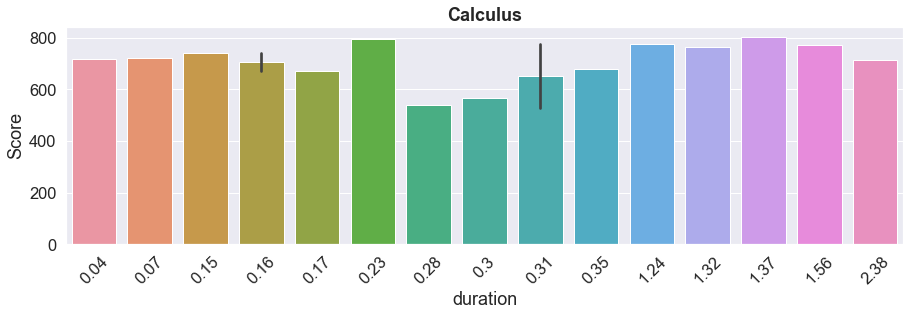

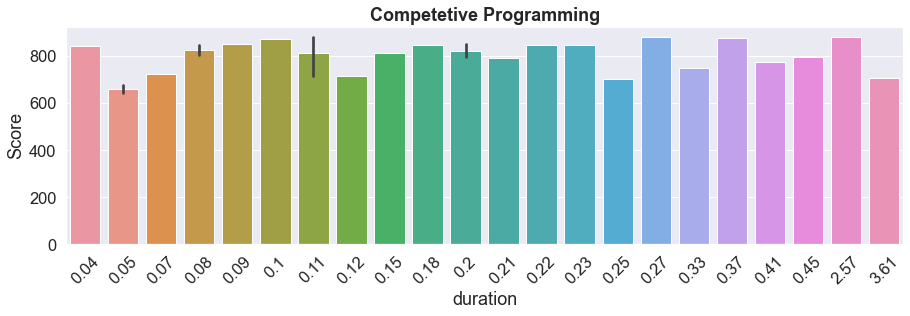

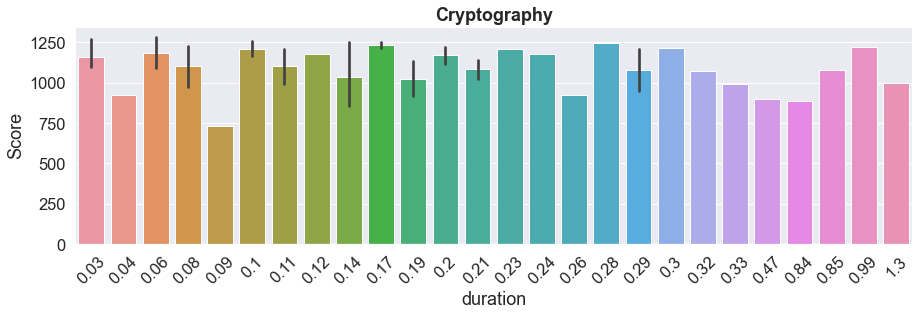

In [56]:
def to_hours(x):
    return round(x.total_seconds()/60/60,2)

for i in range(len(topics)):
    sns.set(font_scale=1.5,rc={'figure.figsize':(15,4)})
    g = sns.barplot(y=dg[i].Score,x=dg[i]['duration'].apply(to_hours))
    plt.setp(g.get_xticklabels(), rotation=45)
    plt.title(topics[i],fontweight = 'bold')
    plt.show(g)
    

## Field Correlations

Field correlations for all the topics 

<Figure size 360x360 with 0 Axes>

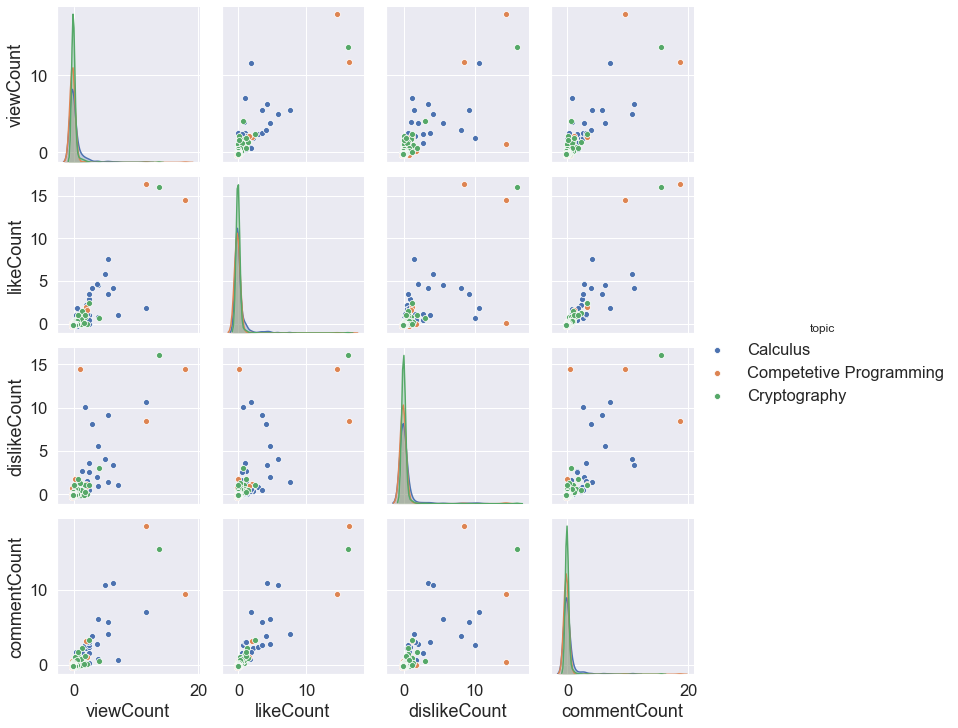

In [63]:
plt.figure(figsize=(5,5))
scored_output_numerical = scored_output[['viewCount','likeCount','dislikeCount' ,'commentCount','topic']]
sns.pairplot( scored_output_numerical, hue='topic')

## Heatmap of likes, dislikes ,views and comment_count

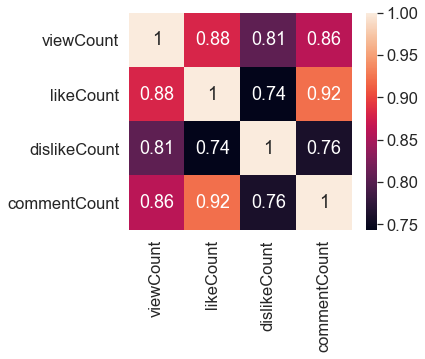

In [95]:
plt.figure(figsize=(5,4))
sns.heatmap( scored_output_numerical.corr(), annot=True)

## Other visualisations
### Word cloud

In [140]:
def createWordCloud(df,topic):
    text = df['Video_Title'].values
    stopwords = set(STOPWORDS) 

    wordcloud2 = WordCloud(width = 500, height = 500, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(text))
    # Generate plot
    plt.figure(figsize = (5, 5), facecolor = None) 

    plt.imshow(wordcloud2)
    plt.tight_layout(pad = 0) 
    plt.axis("off")
    plt.show()

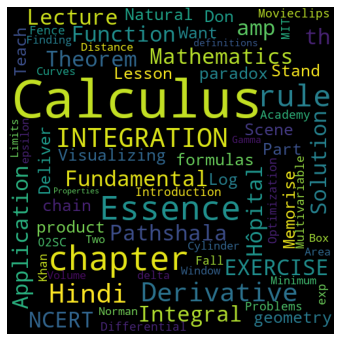

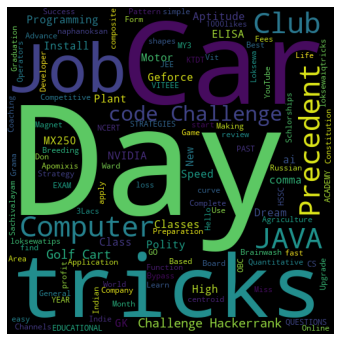

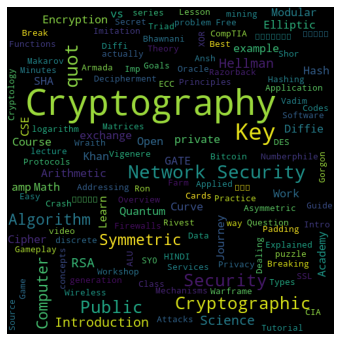

In [141]:
for i in range(len(topics)):
    createWordCloud(dg[i],topics[i])